In [12]:
import sys 
sys.path.insert(1, "../")
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import ast

import dask.dataframe as dd
from dask.dataframe import from_pandas

from workloads.util import use_results, use_dataset, join_queries_features
from workloads.stl.stl_util import predict, predict_seasonality

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from sklearn.linear_model import LogisticRegression

# Read Experiment Data 
* Currently, just read feature results / join against queries for one expeirment 
* Ideally combine together data from different experiments 

In [310]:
experiment = "stl-yahoo-A4-keys-100-interval-10000-events-200000-queries-200000"
results_dir = use_results(experiment)
dataset_dir = use_dataset(experiment)

/data/wooders/ralf-vldb//datasets/stl-yahoo-A4-keys-100-interval-10000-events-200000-queries-200000


In [448]:
result_df = pd.read_csv(f"{results_dir}/results_workers_8_lifo_window_672_slide_12.csv")
result_df["timestamp"] = result_df["processing_time"]
result_df

,key_id,trend,seasonality,timestamp_ms,processing_time,runtime,ingest_time,timestamp
0,42,"[413.50140949485376, 396.1760244530685, 377.78...","[-351.4205882710225, -44.78325598552691, 368.5...",3355,1.645954e+09,0.292799,1.645954e+09,1.645954e+09
1,4,"[482.0246113152429, 459.9343001902722, 437.761...","[-99.79849082010679, 4.077999922742347, 132.70...",3355,1.645954e+09,0.338681,1.645954e+09,1.645954e+09
2,5,"[325.14456469249535, 314.93765609009955, 303.6...","[-99.25521218963091, 61.430315676172256, 209.1...",3355,1.645954e+09,0.328379,1.645954e+09,1.645954e+09
3,2,"[323.98134828170276, 313.68375420539604, 303.3...","[-28.335619341240932, -11.35003663412446, 52.7...",3355,1.645954e+09,0.357376,1.645954e+09,1.645954e+09
4,80,"[-97.6768152190126, -64.14206970655476, -29.83...","[-304.6802655676314, -37.32961939426585, 383.1...",3415,1.645954e+09,0.099798,1.645954e+09,1.645954e+09
...,...,...,...,...,...,...,...,...
5219,15,"[967.0129932824905, 936.1746877479683, 904.216...","[-235.39566451507784, -39.39868088594254, 306....",7795,1.645954e+09,0.100026,1.645954e+09,1.645954e+09
5220,65,"[-254.42103498681615, -243.1875311168469, -231...","[-190.17163699730108, 13.888805726117207, 137....",6535,1.645954e+09,0.099825,1.645954e+09,1.645954e+09
5221,71,"[1212.4923576379688, 1172.890952984519, 1131.4...","[-88.08491782740799, 5.601087805288033, -79.26...",8515,1.645954e+09,0.100629,1.645954e+09,1.645954e+09
5222,2,"[-524.7945964698117, -561.1962904853799, -598....","[-88.28229831433687, -24.228508378939118, 145....",7795,1.645954e+09,0.099837,1.645954e+09,1.645954e+09


In [449]:
timestamp_df = pd.read_csv(f"{results_dir}/results_workers_8_lifo_window_672_slide_12_timestamps.csv")
queries_df = pd.read_csv(f"{dataset_dir}/queries.csv")
queries_df = queries_df.merge(timestamp_df, on="timestamp_ms")

In [452]:
joined_df = join_queries_features(queries_df, result_df) #, time_field="timestamp_ms")

100%|██████████| 194600/194600 [02:48<00:00, 1153.67it/s]


In [487]:
joined_df.to_csv(f"{results_dir}/query_results_workers_8_lifo_window_672_slide_12.csv")

In [488]:
joined_df = pd.read_csv(f"{results_dir}/query_results_workers_8_lifo_window_672_slide_12.csv")
joined_df["seasonality"] = joined_df['seasonality'].apply(ast.literal_eval)
joined_df["trend"] = joined_df['trend'].apply(ast.literal_eval)

In [481]:
df = queries_df.merge(joined_df, on=["query_id", "key_id"], suffixes=('_query', '_feature'))

In [482]:
df["prediction"] = df.dropna().apply(lambda x: predict(
        int(x["value"]), 
        int(x["trend"][-1]), 
        x["seasonality"], 
        int(x["timestamp_ms_query"]), 
        int(x["timestamp_ms_feature"]), 
        interval=5
), axis=1)

ValueError: invalid literal for int() with base 10: ']'

In [483]:
df

,Unnamed: 0,key_id,value,timestamp_ms_query,query_id,timestamp_query,trend,seasonality,timestamp_ms_feature,processing_time,runtime,ingest_time,timestamp_feature,query_key_id,query_timestamp
0,83061,42,-505.902420,5305,83061,1.645954e+09,"[413.50140949485376, 396.1760244530685, 377.78...","[-351.4205882710225, -44.78325598552691, 368.5...",3355,1.645954e+09,0.292799,1.645954e+09,1.645954e+09,42.0,1.645954e+09
1,7062,4,-891.779759,5310,7062,1.645954e+09,"[482.0246113152429, 459.9343001902722, 437.761...","[-99.79849082010679, 4.077999922742347, 132.70...",3355,1.645954e+09,0.338681,1.645954e+09,1.645954e+09,4.0,1.645954e+09
2,9062,5,408.137169,5310,9062,1.645954e+09,"[325.14456469249535, 314.93765609009955, 303.6...","[-99.25521218963091, 61.430315676172256, 209.1...",3355,1.645954e+09,0.328379,1.645954e+09,1.645954e+09,5.0,1.645954e+09
3,83062,42,-544.270740,5310,83062,1.645954e+09,"[413.50140949485376, 396.1760244530685, 377.78...","[-351.4205882710225, -44.78325598552691, 368.5...",3355,1.645954e+09,0.292799,1.645954e+09,1.645954e+09,42.0,1.645954e+09
4,7063,4,-1156.092325,5315,7063,1.645954e+09,"[482.0246113152429, 459.9343001902722, 437.761...","[-99.79849082010679, 4.077999922742347, 132.70...",3355,1.645954e+09,0.338681,1.645954e+09,1.645954e+09,4.0,1.645954e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75426,89945,45,-1674.640299,9725,89945,1.645954e+09,"[890.6799352711653, 835.0609331686235, 778.203...","[-93.65491311252241, 52.10168083338446, 114.28...",5275,1.645954e+09,0.113866,1.645954e+09,1.645954e+09,45.0,1.645954e+09
75427,57945,29,5748.447830,9725,57945,1.645954e+09,"[1227.1629593867563, 1191.35184212838, 1154.45...","[-214.2882965549398, 42.24110947669054, 335.88...",4915,1.645954e+09,0.135964,1.645954e+09,1.645954e+09,29.0,1.645954e+09
75428,11945,6,-688.506556,9725,11945,1.645954e+09,"[-1652.8164858163443, -1640.5626298715001, -16...","[-36.18377271185266, 1.5500695110045017, 40.69...",5755,1.645954e+09,0.117491,1.645954e+09,1.645954e+09,6.0,1.645954e+09
75429,163945,82,0.564617,9725,163945,1.645954e+09,"[-128.9678098687391, -122.50319322648697, -115...","[-280.8737171791377, -4.363101414603113, 177.2...",5695,1.645954e+09,0.106012,1.645954e+09,1.645954e+09,82.0,1.645954e+09


In [418]:
oracle_df = pd.read_csv(f"{dataset_dir}/oracle_features_672.csv").dropna()
oracle_df["seasonality"] = oracle_df['seasonality'].dropna().apply(ast.literal_eval)

In [419]:
oracle_query_df = queries_df.merge(oracle_df, on=["timestamp_ms", "key_id", "value"])

In [420]:
oracle_query_df["prediction"] = oracle_query_df.dropna().apply(lambda x: predict(
        int(x["value"]), 
        int(x["trend"]), 
        x["seasonality"], 
        int(x["timestamp_ms"]), 
        int(x["timestamp_ms"]), 
        interval=5
    ), axis=1)
oracle_query_df

,Unnamed: 0_x,key_id,value,timestamp_ms,query_id,timestamp,Unnamed: 0_y,trend,noise,outlier,seasonality,timestamp_ms.1,key_id.1,prediction
0,10671,6,-2031.731179,3355,10671,1.645951e+09,671,-1722.138682,-179.562225,0.0,"[-438.41445878371496, 20.915651101082947, 559....",3355,6,129.414459
1,174671,88,-1352.079809,3355,174671,1.645951e+09,671,-1117.348807,58.546443,0.0,"[-323.39704044739165, -155.26029226523005, 277...",3355,88,88.397040
2,192671,97,1859.207978,3355,192671,1.645951e+09,671,2045.857039,15.302189,0.0,"[-217.73544291946482, 85.50421590502249, 262.7...",3355,97,31.735443
3,86671,44,131.709271,3355,86671,1.645951e+09,671,1111.006064,-65.864757,0.0,"[-748.6440428397661, 177.99368904123864, 465.8...",3355,44,-231.355957
4,136671,69,-272.363200,3355,136671,1.645951e+09,671,5.953501,-11.702695,0.0,"[-267.0470758299926, -64.21271713979031, 378.8...",3355,69,-9.952924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78995,173460,87,-2414.999116,7300,173460,1.645951e+09,1460,-1940.885486,93.456447,0.0,"[-795.8505411478488, -478.64419521003003, -564...",7300,87,321.850541
78996,29460,15,-946.835958,7300,29460,1.645951e+09,1460,280.758953,-29.059106,0.0,"[-1234.9620627699585, -1260.8666686312122, -10...",7300,15,8.962063
78997,77460,39,-608.001611,7300,77460,1.645951e+09,1460,622.476662,204.550316,0.0,"[-1045.932908022117, -1558.0548753162748, -135...",7300,39,-184.067092
78998,155460,78,2158.280904,7300,155460,1.645951e+09,1460,2354.421499,-14.488157,0.0,"[-215.34457360812925, -133.12153034306652, -89...",7300,78,19.344574


In [421]:
oracle_query_df = oracle_query_df.set_index("query_id")

# Generate Training Dataset 

In [465]:
# x = [(staleness, key)], # y = [(error)]

X = []
Y = [] 

for key in range(1, 101, 1):
    X.append((0, key))
    Y.append(0)
    
#for index, row in oracle_query_df.iterrows():
#    error = row["noise"] - row["prediction"]
#    X.append((0, row["key_id"]))
#    Y.append(error)
    
    
for index, row in df.iterrows():
    staleness = row["timestamp_ms_query"] - row["timestamp_ms_feature"]
    
    # error can be either compared with oracle prediction or ground truth 
    error = oracle_query_df.loc[row["query_id"]]["prediction"] - row["prediction"]
    X.append((staleness, row["key_id"]))
    Y.append(error)
    #print(X[-1], error)
    
    
    
    

In [466]:
(df["timestamp_ms_query"] - df["timestamp_ms_feature"]).min()

105

In [467]:
(df["timestamp_ms_query"] - df["timestamp_ms_feature"]).max()

3945

## Create Linear Model Per-Key 
TODO: Make this just one model 

In [478]:
import math

models = {}
for key in range(1, 101, 1): 
    s = []
    e = []
    for i in range(len(X)):
        if X[i][1] == key: 
            #if Y[i]*Y[i] > 10000: continue
            #if X[i][0] > 1000: continue  
                
            s.append(X[i][0])
            e.append(math.sqrt(Y[i]*Y[i]))
            #print(X[i], Y[i])

    clf = LinearRegression().fit([[x] for x in s], e)
    models[key] = {"x": s, "y": e, "model": clf}
        

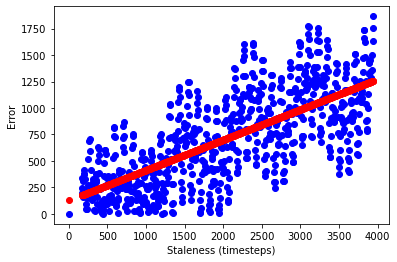

In [479]:
import matplotlib.pyplot as plt

# plot single key 

key = 2
plt.scatter(models[key]["x"], models[key]["y"], c ="blue")
plt.scatter(models[key]["x"], [models[key]["model"].predict([[x] for x in models[key]["x"]])], c ="red")
plt.ylabel("Error")
plt.xlabel("Staleness (timesteps)")
plt.show()

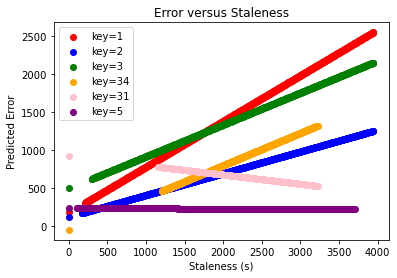

In [480]:
import matplotlib.pyplot as plt

# compare multiple keys 

key = 1 
plt.scatter(models[key]["x"], [models[key]["model"].predict([[x] for x in models[key]["x"]])], c ="red", label=f"key={key}")
 
key = 2 
plt.scatter(models[key]["x"], [models[key]["model"].predict([[x] for x in models[key]["x"]])], c ="blue", label=f"key={key}")
 
key = 3
plt.scatter(models[key]["x"], [models[key]["model"].predict([[x] for x in models[key]["x"]])], c ="green", label=f"key={key}")
 
key = 34
plt.scatter(models[key]["x"], [models[key]["model"].predict([[x] for x in models[key]["x"]])], c ="orange", label=f"key={key}")
 
 
key = 31
plt.scatter(models[key]["x"], [models[key]["model"].predict([[x] for x in models[key]["x"]])], c ="pink", label=f"key={key}")
 
key = 5
plt.scatter(models[key]["x"], [models[key]["model"].predict([[x] for x in models[key]["x"]])], c ="purple", label=f"key={key}")
 
plt.legend()
# To show the plot
plt.title("Error versus Staleness")
plt.ylabel("Predicted Error")
plt.xlabel("Staleness (s)")
plt.show()

In [450]:
result_df[result_df["key_id"] == 11].processing_time - result_df[result_df["key_id"] == 11].processing_time.min()

213      0.000000
253      0.622673
343      2.020175
561      5.299585
609      6.000737
652      6.698329
727      7.867527
870     10.134079
896     10.511646
1134    14.212401
1204    15.392863
1286    16.655102
1497    19.985424
1683    22.879620
1734    23.747447
1799    24.763682
2021    28.218629
2158    30.163760
2200    30.817127
2406    33.669544
2549    35.635497
2770    38.549351
2884    40.053638
2998    41.542296
3106    43.014652
3228    44.605363
3340    46.068582
3454    47.579505
3678    50.599249
3910    53.660866
4031    55.273854
4142    56.770680
4256    58.224740
4377    59.779268
4611    62.822875
4723    64.277147
4836    65.749624
4947    67.213619
5060    68.676995
5180    70.246612
Name: processing_time, dtype: float64

In [451]:
timestamp_df.timestamp - result_df.ingest_time.min()

0       -9.882686
1       -9.875376
2       -9.872350
3       -9.869998
4       -9.867785
          ...    
9725    18.371479
9726    18.375740
9727    18.377908
9728    18.380052
9729    18.382220
Name: timestamp, Length: 9730, dtype: float64

In [437]:
df[df["key_id"] == 11]

,Unnamed: 0_query,key_id,value,timestamp_ms_query,query_id,timestamp_query,Unnamed: 0_feature,trend,seasonality,timestamp_ms_feature,processing_time,runtime,ingest_time,timestamp_feature,query_key_id,query_timestamp,prediction
661,20810,11,327.747364,4050,20810,1.645951e+09,11987,"[360.752198332339, 350.38548543827534, 339.671...","[-27.495448820266997, -14.737450944414018, 35....",3595,1.645947e+09,0.129996,1.645947e+09,1.645947e+09,11.0,1.645947e+09,-289.221697
672,20811,11,265.241744,4055,20811,1.645951e+09,11988,"[360.752198332339, 350.38548543827534, 339.671...","[-27.495448820266997, -14.737450944414018, 35....",3595,1.645947e+09,0.129996,1.645947e+09,1.645947e+09,11.0,1.645947e+09,-321.273252
689,20812,11,221.641215,4060,20812,1.645951e+09,11989,"[360.752198332339, 350.38548543827534, 339.671...","[-27.495448820266997, -14.737450944414018, 35....",3595,1.645947e+09,0.129996,1.645947e+09,1.645947e+09,11.0,1.645947e+09,-337.965575
702,20813,11,238.833567,4065,20813,1.645951e+09,11990,"[360.752198332339, 350.38548543827534, 339.671...","[-27.495448820266997, -14.737450944414018, 35....",3595,1.645947e+09,0.129996,1.645947e+09,1.645947e+09,11.0,1.645947e+09,-313.261863
715,20814,11,244.655317,4070,20814,1.645951e+09,11991,"[360.752198332339, 350.38548543827534, 339.671...","[-27.495448820266997, -14.737450944414018, 35....",3595,1.645947e+09,0.129996,1.645947e+09,1.645947e+09,11.0,1.645947e+09,-319.761705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30175,21456,11,-1360.578156,7280,21456,1.645951e+09,12633,"[360.752198332339, 350.38548543827534, 339.671...","[-27.495448820266997, -14.737450944414018, 35....",3595,1.645947e+09,0.129996,1.645947e+09,1.645947e+09,11.0,1.645947e+09,-2054.167847
30212,21457,11,-1588.934019,7285,21457,1.645951e+09,12634,"[360.752198332339, 350.38548543827534, 339.671...","[-27.495448820266997, -14.737450944414018, 35....",3595,1.645947e+09,0.129996,1.645947e+09,1.645947e+09,11.0,1.645947e+09,-2237.454466
30358,21458,11,-1989.912430,7290,21458,1.645951e+09,12635,"[360.752198332339, 350.38548543827534, 339.671...","[-27.495448820266997, -14.737450944414018, 35....",3595,1.645947e+09,0.129996,1.645947e+09,1.645947e+09,11.0,1.645947e+09,-2605.221697
30425,21459,11,-2347.631116,7295,21459,1.645951e+09,12636,"[360.752198332339, 350.38548543827534, 339.671...","[-27.495448820266997, -14.737450944414018, 35....",3595,1.645947e+09,0.129996,1.645947e+09,1.645947e+09,11.0,1.645947e+09,-2933.273252


In [398]:
results_df

,key_id,trend,seasonality,timestamp_ms,processing_time,runtime,ingest_time
0,3,"[419.31845773581836, 409.8891026490037, 398.98...","[-111.69095355486074, 13.102169337779117, 179....",3355,1.645945e+09,0.432117,1.645945e+09
1,1,"[171.02647712020985, 165.23367108783776, 159.0...","[-51.17800825485405, -24.535171020787708, 87.5...",3355,1.645945e+09,0.100625,1.645945e+09
2,2,"[327.5775368367989, 316.6151729890695, 305.645...","[-28.368407719026756, -9.086808902404467, 50.4...",3355,1.645945e+09,0.111522,1.645945e+09
3,9,"[284.31049718183885, 264.61067938387333, 244.5...","[-225.63425192815072, 160.09397119649282, 512....",3355,1.645945e+09,0.116345,1.645945e+09
4,4,"[482.7929979970962, 460.59523275292946, 438.32...","[-99.94783888534685, 8.862942571191041, 130.30...",3355,1.645945e+09,0.087770,1.645945e+09
...,...,...,...,...,...,...,...
187,95,"[2802.833459888745, 2765.696373939382, 2726.49...","[-72.23392464313721, -3.875588913522293, 169.8...",6715,1.645945e+09,0.098421,1.645945e+09
188,87,"[-447.38312171540343, -491.0541079877247, -535...","[-87.40559121381266, -34.50672589259393, 173.5...",6715,1.645945e+09,0.098246,1.645945e+09
189,96,"[381.36075934807036, 354.89043556285344, 328.1...","[-52.077695312150695, 13.899364817866669, 102....",6715,1.645945e+09,0.098887,1.645945e+09
190,97,"[2167.8885600023527, 2166.77568818848, 2165.19...","[-75.80266468718915, 1.69859059499014, 107.361...",6715,1.645945e+09,0.098145,1.645945e+09


In [409]:
del results_df